In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from rdkit import Chem

from pipeline import draw_mols

/Users/jackie16201/opt/anaconda3/envs/torch_environment/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jackie16201/Desktop/Spring_2023/fragments_discovery_design_ML/src/pipeline.py:12: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  from rdkit.Chem import MCS


# Assess activity of known antibacterial fragments

In [2]:
def convert_str_to_mol(s: str) -> Chem.Mol:
    """Convert string to molecule.
    
    :param s: str representation of compound
    :returns: Mol
    """
    return Chem.MolFromSmiles(s)

nitrofuran = 'O=[N+](O)c1ccco1'
nitro_mol = convert_str_to_mol(nitrofuran)

fluoroquinolone = 'O=C(O)c2c[nH]c1ccc(F)cc1c2=O'
fluoroquino_mol = convert_str_to_mol(fluoroquinolone)

carbapenem = 'O=C(O)C1=CCC2CC(=O)N12'
carbapenem_mol = convert_str_to_mol(carbapenem)

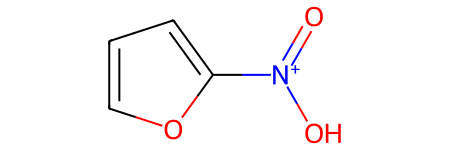

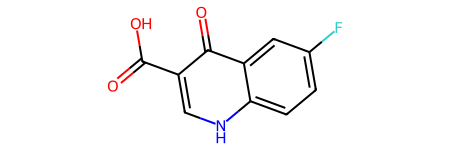

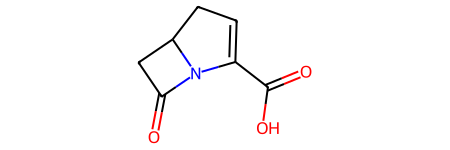

In [4]:
smis = [nitrofuran,fluoroquinolone,carbapenem]
labs = ['nitrofuran','fluoroquinolone','carbapenem']

df = pd.DataFrame()
df['SMILES'] = smis
df['Fragment'] = labs
df['Type'] = ['Fragment'] * len(df)

# look for these fragments within our set of known antibiotics
abx = pd.read_csv('../data/static_datasets/04052022_CLEANED_v5_antibiotics_across_many_classes.csv')
abx_mols = [Chem.MolFromSmiles(smi) for smi in abx['Smiles']]

frags = [nitro_mol, fluoroquino_mol, carbapenem_mol]
for i, frag in enumerate(frags):
    display(frag)
    contains = [m.HasSubstructMatch(frag) if m is not None else False for m in abx_mols]
    curr_abx = abx[contains]
    curr_abx = curr_abx[['ChEMBL ID', 'Smiles', 'Class-Annotated']]
    curr_abx.columns = ['ChEMBL ID', 'SMILES', 'Class']
    curr_abx['Fragment'] = [labs[i]] * len(curr_abx)
    curr_abx['Type'] = ['Full Compound'] * len(curr_abx)
    
    df = pd.concat([df, curr_abx])
df.to_csv('../out/controls/known_antibiotics_containing_frags.csv', index = False)

Run from the command line (paths may be different - could also use subprocess to run within the notebook):

`chemprop_predict --test_path ../out/controls/known_antibiotics_containing_frags.csv --checkpoint_dir ../models/SA/revised_sa_model/Checkpoints/ --preds_path ../out/controls/known_antibiotics_containing_frags_with_SA_scores.csv --features_generator rdkit_2d_normalized --no_features_scaling --smiles_column SMILES`

`python ../models/chemprop-master/scripts/save_features.py --data_path ../out/controls/known_antibiotics_containing_frags.csv --features_generator rdkit_2d_normalized --save_path ../out/controls/known_antibiotics_containing_frags --smiles_column SMILES`

`chemprop_predict --test_path ../out/controls/known_antibiotics_containing_frags.csv --checkpoint_dir ../models/NG/FINALbayHO11152022/ --preds_path ../out/controls/known_antibiotics_containing_frags_with_NG_scores.csv --features_path ../out/controls/known_antibiotics_containing_frags.npz --no_features_scaling --smiles_column SMILES`

# Make figure

In [3]:
# read back in predictions
df = pd.read_csv('../out/controls/known_antibiotics_containing_frags.csv')
df = df.reset_index(drop = True)

# SA - scores
sa_df = pd.read_csv('../out/controls/known_antibiotics_containing_frags_with_SA_scores.csv')
scores = list(sa_df['ACTIVITY'])
sa_df = df.copy()
sa_df['Score'] = scores
sa_df['Model'] = ['S. aureus'] * len(df)

# NG - scores
ng_df = pd.read_csv('../out/controls/known_antibiotics_containing_frags_with_NG_scores.csv')
scores = list(ng_df['hit'])
ng_df = df.copy()
ng_df['Score'] = scores
ng_df['Model'] = ['N. gonorrhoeae'] * len(df)

df = pd.concat([sa_df, ng_df])

/Users/jackie16201/opt/anaconda3/envs/torch_environment/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/jackie16201/opt/anaconda3/envs/torch_environment/lib/python3.10/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the violinplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/jackie16201/opt/anaconda3/envs/torch_environment/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/jackie16201/opt/anaconda3/envs/torch_environment/lib/python3.10/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the stripplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 2400x1500 with 0 Axes>

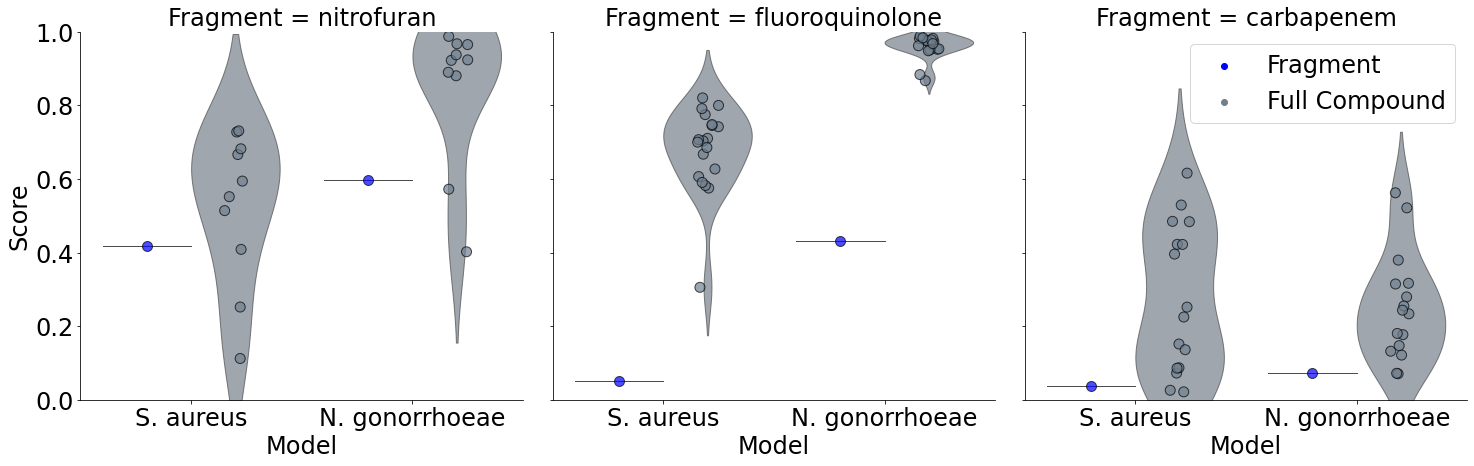

In [4]:
plt.figure(figsize=(8,5), dpi=300)
font = {'size'   : 24}
matplotlib.rc('font', **font)
    
my_pal = dict(zip(['Fragment', 'Full Compound'], ['blue', 'slategrey']))

g = sns.FacetGrid(df, col='Fragment', height=7, aspect=1, margin_titles=True)
g.map(sns.violinplot, 'Model', 'Score', 'Type', dodge = True, edgecolor='black', linewidth = 1, errcolor = 'black', inner = None, saturation = 0.6, palette = my_pal)
g.map(sns.stripplot, 'Model', 'Score', 'Type', dodge = True, edgecolor='black', alpha = 1, linewidth = 1, s = 10, palette = my_pal)

for i, ax in enumerate(g.axes_dict.values()):
    if i == len(set(df['Fragment'])) - 1:
        
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[2:4], labels[2:4], title='', loc = 'upper right')    
    plt.xlabel('Model')
    plt.setp(ax.collections, alpha=.7)
    plt.ylim([0,1.0])
    plt.xticks(rotation = 0)
    plt.ylabel('Score')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()

plt.savefig('../figure_panels/known_antibiotics_containing_frags.svg')
plt.savefig('../figure_panels/known_antibiotics_containing_frags.png')
plt.show()


In [7]:
draw_mols(frags, legends='', file_path = '../figure_panels/known_antibiotics_containing_frags_with_mols.png', black_and_white=True)